In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyproj

In [2]:
def haversine_np(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km


# define_clusters: given a geopandas dataframe with shapely POINT geometry in EPSG:4087 format,
#                  performs a series of operations to cluster observations that collectively share
#                  neighborbood relationships in 2D distance, pressure, time, u-component wind, and
#                  v-component wind within defined threshold maximum values
#
# INPUTS:
#
# gdfE: geopandas dataframe containing observations to operate on, MUST have a gdfE['geometry'] in
#       shapely POINT values with crs=EPSG:4087 (cylindrical equidistant projection, differences in m).
#       Presumed dataframe columns
#         geometry (shapely.geometry.Point())
#         lat (float, degrees)
#         lon (float, degrees)
#         pre (float, hPa)
#         tim (float, fractional hours relative to analysis time, i.e. location in time-window)
#         uob (float, m/s)
#         vob (float, m/s)
#         obIndex (integer, index in full ob vector)
#         clusterIndex (integer, initialized to all -1 values)
# thresholdDistance: maximum allowable distance (m) between observations to define neighborhood
# thresholdPressure: maximum allowable pressure difference (hPa) between observations to define neighborhood
# thresholdTime: maximum allowable time difference (hrs) between observations to define neighborhood
# thresholdUwnd: maximum allowable u-wind difference (m/s) between observations to define neighborhood
# thresholdVwnd: maximum allowable v-wind difference (m/s) between observations to define neighborhood
#
# OUTPUTS:
#
# gdfE2: geopandas dataframe with 'clusterIndex' filled, defining each cluster in dataset
#
# DEPENDENCIES:
#
# numpy
# geopandas
# pandas
# shapely.geometry.Point
# pysal
# libpysal
# sklearn.neighbors.NearestNeighbors
def define_clusters(gdfE, thresholdDistance, thresholdPressure, thresholdTime, thresholdUwnd, thresholdVwnd):
    import numpy as np
    import geopandas as gpd
    import pandas as pd
    from shapely.geometry import Point
    from netCDF4 import Dataset
    import libpysal
    from sklearn.neighbors import NearestNeighbors
    #########################################################################################################
    #
    # Compute 2D distance relationships between observations using libpysal weights
    #
    # use libpysal.weights.distance.DistanceBand.from_dataframe() to compute a system of weights
    # identifying observations that are within thresholdDistance of each other. Warnings are silenced
    # but with silence_warnings=False you will see warnings of the form:
    #
    # "UserWarning: The weights matrix is not fully connected:"
    # " There are {n1} disconnected components."
    # " There are {n2} islands with ids: ..."
    #
    # We will use both the disconnected components information and the islands information when
    # processing observations, but we can squelch the warnings since we don't need to report this
    # information to the screen.
    w = libpysal.weights.distance.DistanceBand.from_dataframe(df=gdfE,
                                                              threshold=thresholdDistance,
                                                              binary=True,
                                                              ids=None,
                                                              build_sp=True,
                                                              silence_warnings=True,
                                                              distance_metric='euclidean',
                                                              radius=None)
    # We can immediately trim the islands off of gdfE, these are observations with no neighbors
    # withing thresholdDistance and as a result will definitively be single-member clusters. These
    # will be appended back into gdfE at the end and assigned their own clusterIndex values, but
    # for now we can remove them from the rest of the algorithm's operations.
    # Create separate geopandas dataframe to contain islands
    gdfE_islands = gdfE.iloc[w.islands]
    # Reset the index numbering of gdfE_islands
    gdfE_islands = gdfE_islands.reset_index() # moves existing index-values to 'index'
    # Drop gdfE_islands indices from gdfE
    gdfE=gdfE.drop(index=w.islands)
    # Reset the index numbering of gdfE
    gdfE = gdfE.reset_index() # moves existing index-values to 'index'
    # Re-run libpysal.weights.distance.DistanceBand.from_dataframe() on gdfE without islands,
    # which will yield data only across non-island data
    w = libpysal.weights.distance.DistanceBand.from_dataframe(df=gdfE,
                                                              threshold=thresholdDistance,
                                                              binary=True,
                                                              ids=None,
                                                              build_sp=True,
                                                              silence_warnings=True,
                                                              distance_metric='euclidean',
                                                              radius=None)
    # w generates information on component-groups, which are collectively interconnected observations that
    # are not connected to any observations outside of the component-group. For example, a set of 5
    # observations that share distance < thresholdDistance relationships between each other, but none of
    # those 5 observations has a similar relationship outside of the group, would be a component-group. These
    # component-groups serve as natural dividing-lines between the observations in the dataset: knowing that
    # no observations within a component-group are connected to observations outside of the component-group,
    # clusters can be searched-for within each component-group individually. We will use this information
    # to break up the task of searching for neighbors in other spaces (pressure, time, u-wind, v-wind) only
    # within a component-group.
    #
    # Assign the w.component_label value for each observation to gdfE as 'compGroup'
    gdfE = gdfE.assign(compGroup=w.component_labels)
    # Assign a -1 value to 'compGroup' in all members in gdfE_islands to flag them as islands
    gdfE_islands = gdfE_islands.assign(compGroup=-1)
    #########################################################################################################
    #
    # Search for clusters within each component-group of the data
    #
    # Define a cluster index value
    clusterID = -1  # first valid cluster will increment, so clusterIndex will begin at 0
    # Loop over component-groups
    for ic in np.unique(gdfE['compGroup'].values):
        # Extract all component-neighbors from a component-group and place into a gdfEsub geopandas dataframe
        gdfEsub = gdfE.loc[gdfE['compGroup']==ic]
        # Compute proximity-neighbor lists among members of component-group
        # pressure
        neighPres = NearestNeighbors(radius=thresholdPressure)
        neighPres.fit(np.reshape(gdfEsub['pre'].values,(-1,1)))
        neighPresList = neighPres.radius_neighbors(np.reshape(gdfEsub['pre'].values,(-1,1)),return_distance=False)
        # time
        neighTime = NearestNeighbors(radius=thresholdTime)
        neighTime.fit(np.reshape(gdfEsub['tim'].values,(-1,1)))
        neighTimeList = neighTime.radius_neighbors(np.reshape(gdfEsub['tim'].values,(-1,1)),return_distance=False)
        # u-wind
        neighUwnd = NearestNeighbors(radius=thresholdUwnd)
        neighUwnd.fit(np.reshape(gdfEsub['uob'].values,(-1,1)))
        neighUwndList = neighUwnd.radius_neighbors(np.reshape(gdfEsub['uob'].values,(-1,1)),return_distance=False)
        # v-wind
        neighVwnd = NearestNeighbors(radius=thresholdVwnd)
        neighVwnd.fit(np.reshape(gdfEsub['vob'].values,(-1,1)))
        neighVwndList = neighVwnd.radius_neighbors(np.reshape(gdfEsub['vob'].values,(-1,1)),return_distance=False)
        # Reset index-values of gdfEsub
        gdfEsub = gdfEsub.reset_index()  # moves existing index-values to 'level_0'
        # Loop through subgroup
        for i in range(len(gdfEsub)):
            # Check if observation i still needs to be assigned to a cluster, if not, skip this loop
            # NOTE: Including this if-check reduces the total number of clusters (i.e. generates larger
            #       clusters) and affects the standard-deviation statistics. It would be worth figuring
            #       out exactly *why* this change takes place.
            if gdfEsub.iloc[i]['clusterIndex'] == -1:
                # Increment clusterID
                clusterID = clusterID + 1
                # Define proximity, pressure, time, and u/v similarity neighbors among subgroup members
                # proxlist will never include observation i as a member
                proxlist = np.where(np.isin(gdfEsub['level_0'].values, w.neighbors[gdfEsub['level_0'].values[i]]))[0]
                # {pres,time,uwnd,vwnd}list will always include observation i as a member
                preslist = neighPresList[i]
                timelist = neighTimeList[i]
                uwndlist = neighUwndList[i]
                vwndlist = neighVwndList[i]
                # Define cluster members by intersection of all neighborhoods
                # since proxlist does not include observation i, it is dropped from the cluster here
                cluster = np.intersect1d(proxlist, preslist)
                cluster = np.intersect1d(cluster, timelist)
                cluster = np.intersect1d(cluster, uwndlist)
                cluster = np.intersect1d(cluster, vwndlist)
                # Add member i back into cluster
                cluster = np.append(i, cluster)
                # Assign any member of cluster with a -1 (unassigned) clusterIndex to clusterID
                gdfEsub.iloc[cluster, gdfEsub.columns.get_loc('clusterIndex')] = np.where(gdfEsub.iloc[cluster, gdfEsub.columns.get_loc('clusterIndex')]==-1,
                                                                                          clusterID,
                                                                                          gdfEsub.iloc[cluster, gdfEsub.columns.get_loc('clusterIndex')])
        # Assign corresponding members of gdfE a clusterIndex value from gdfEsub, following clustering
        # on component-group 
        gdfE.set_index('index', inplace=True)
        gdfE.update(gdfEsub.set_index('index'))
        gdfE = gdfE.reset_index()  # to recover the initial structure
        # Reassert column types (integers tend to turn into floats after update)
        convert_dict = {'ob_idx': int,
                        'clusterIndex': int,
                        'compGroup': int
                       }
        gdfE = gdfE.astype(convert_dict)
        # Reassert gdfE crs as EPSG:4087 (tends to get dropped after update, further updates give warnings
        # about missing crs if this isn't done)
        gdfE = gdfE.set_crs("EPSG:4087")
    #########################################################################################################
    #
    # Assign clusterIndex values to single-member clusters in gdfE_islands and merge dataframes
    #
    # Assign each observation in gdfE_islands to its own cluster, incrementing from max(gdfE['clusterIndex'])
    gdfE_islands['clusterIndex'] = np.arange(max(gdfE['clusterIndex']) + 1, max(gdfE['clusterIndex']) + 1 + len(gdfE_islands))
    # Concatenate gdfE and gdfE_islands together to regenerate entire dataframe
    gdfE2 = gpd.GeoDataFrame(pd.concat([gdfE,gdfE_islands], ignore_index=True, verify_integrity=False, sort=False))
    # Sort gdfE2 by 'index' values and assert 'index' as dataframe index to put gdfE_islands back in-place in
    # the proper order to match input gdfE dataframe
    gdfE2 = gdfE2.sort_values('index')
    gdfE2.set_index('index', inplace=True)
    # Return gdfE2
    return gdfE2

In [3]:
data_dir='test-data/ops.v16.3.2023040300'
diag_file=data_dir+'/diag_conv_uv_ges.2023040300.nc4'
diag_hdl=Dataset(diag_file)
ob_use=np.asarray(diag_hdl.variables['Analysis_Use_Flag']).squeeze()
ob_typ=np.asarray(diag_hdl.variables['Observation_Type']).squeeze()
ob_sty=np.asarray(diag_hdl.variables['Observation_Subtype']).squeeze()
ob_pre=np.asarray(diag_hdl.variables['Pressure']).squeeze()
ob_lat=np.asarray(diag_hdl.variables['Latitude']).squeeze()
ob_lon=np.asarray(diag_hdl.variables['Longitude']).squeeze()
ob_tim=np.asarray(diag_hdl.variables['Time']).squeeze()
ob_uwd=np.asarray(diag_hdl.variables['u_Observation']).squeeze()
ob_vwd=np.asarray(diag_hdl.variables['v_Observation']).squeeze()
fix=np.where(ob_lon>180.)
ob_lon[fix]=ob_lon[fix]-360.

In [4]:
# Pre-screening for pressure and time into discrete groups, then use DistanceBand grouping
# and pressure/time NearestNeighbors against all obs to reach out and include obs outside
# of initial screening. Use this expanded group to test for similarity via clustering with
# affinity propagation
#
# Perform similarity-based clustering on DistanceBand connected-groups, which can include
# multiple proximity-based clusters but will contain no observations with proximity-neighbors
# outside of the connected-group.
#
# define index of all qualifiable observations (meeting use and typ requirements)
allidx=np.where((ob_use==1.)&(ob_typ>=240)&(ob_typ<=260))[0]
# define index of all searching observations (meeting pressure and time requirements in subset)
thresDist = 100. * 1000.  # range of distance for clustering
thresPres = 50. # +/- range of pressure bin
thresTime = 0.5  # +/- range of time bin
thresUwnd = 5.0  # +/- range of u-wind differences for clustering
thresVwnd = 5.0  # +/- range of v-wind differences for clustering
srcPres = 450.  # center of pressure bin
srcTime = -2.5  # center of time bin
minPres = srcPres - thresPres
maxPres = srcPres + thresPres
minTime = srcTime - thresTime
maxTime = srcTime + thresTime
srcidx=np.intersect1d(allidx,np.where((ob_pre <= maxPres)&(ob_pre >= minPres) &
                                      (ob_tim <= maxTime)&(ob_tim >= minTime))[0])
# define index of all expanding observations (qualifiable and within threshPres and threshTime of pressure/time req.)
minPresExp = minPres - thresPres
maxPresExp = maxPres + thresPres
minTimeExp = minTime - thresTime
maxTimeExp = maxTime + thresTime
expidx=np.intersect1d(allidx,np.where((ob_pre <= maxPresExp)&(ob_pre >= minPresExp) &
                                      (ob_tim <= maxTimeExp)&(ob_tim >= minTimeExp))[0])
print('{:d} observations in total'.format(np.size(allidx)))
print('{:d} observations in search'.format(np.size(srcidx)))
print('{:d} observations in expanded range'.format(np.size(expidx)))

582778 observations in total
13835 observations in search
39721 observations in expanded range


In [5]:
# Construct a geopandas point dataset that contains all relevant ob-info
point_list=[]
nob_list=[]
for i in expidx:
    point_list.append(Point(ob_lon[i],ob_lat[i]))
d = {'geometry': point_list, 
     'lat': list(ob_lat[expidx]),
     'lon': list(ob_lon[expidx]),
     'pre': list(ob_pre[expidx]),
     'tim': list(ob_tim[expidx]),
     'uob': list(ob_uwd[expidx]),
     'vob': list(ob_vwd[expidx]),
     'ob_idx': list(expidx),
     'clusterIndex': -1  # placeholder, -1 == no assigned cluster
    }
gdf = gpd.GeoDataFrame(d, crs="EPSG:4326")
# Transform gdf into cylindrical equidistant projection, where Point() units are in m
gdfE = gdf.to_crs("EPSG:4087")
gdfE

,geometry,lat,lon,pre,tim,uob,vob,ob_idx,clusterIndex
0,POINT (111319.491 -9034690.280),-81.160004,1.000000,425.000000,-2.550000,-3.314330,13.293052,0,-1
1,POINT (939536.456 -9013539.305),-80.970001,8.440000,450.000000,-2.550000,-13.800393,8.292113,1,-1
2,POINT (921725.354 -9082556.846),-81.589996,8.280000,437.000000,-2.550000,-11.190902,9.062214,2,-1
3,POINT (551031.458 -9124858.796),-81.970001,4.950000,412.000000,-2.550000,-8.955636,14.332013,3,-1
4,POINT (732482.241 -9122631.931),-81.949997,6.580000,412.000000,-2.550000,-10.281547,13.159780,4,-1
...,...,...,...,...,...,...,...,...,...
39716,POINT (-391109.589 8010216.681),71.957001,-3.513397,550.000000,-2.300000,9.053615,10.414992,1850177,-1
39717,POINT (-262257.143 8251001.813),74.120010,-2.355896,550.000000,-2.050000,5.768426,9.600274,1850178,-1
39718,POINT (-342295.204 8191590.708),73.586311,-3.074890,537.000000,-2.050000,5.304892,8.828823,1850179,-1
39719,POINT (-374711.299 7996491.138),71.833702,-3.366089,525.000000,-2.050000,9.522121,13.106075,1850181,-1


In [6]:
gdfE2 = define_clusters(gdfE, thresDist, thresPres, thresTime, thresUwnd, thresVwnd)

In [7]:
gdfE2

,geometry,lat,lon,pre,tim,uob,vob,ob_idx,clusterIndex,compGroup
index,,,,,,,,,,
0,POINT (111319.491 -9034690.280),-81.160004,1.000000,425.000000,-2.550000,-3.314330,13.293052,0,14758,-1
1,POINT (939536.456 -9013539.305),-80.970001,8.440000,450.000000,-2.550000,-13.800393,8.292113,1,0,0
2,POINT (921725.354 -9082556.846),-81.589996,8.280000,437.000000,-2.550000,-11.190902,9.062214,2,0,0
3,POINT (551031.458 -9124858.796),-81.970001,4.950000,412.000000,-2.550000,-8.955636,14.332013,3,14759,-1
4,POINT (732482.241 -9122631.931),-81.949997,6.580000,412.000000,-2.550000,-10.281547,13.159780,4,1,0
...,...,...,...,...,...,...,...,...,...,...
39716,POINT (-391109.589 8010216.681),71.957001,-3.513397,550.000000,-2.300000,9.053615,10.414992,1850177,14756,1578
39717,POINT (-262257.143 8251001.813),74.120010,-2.355896,550.000000,-2.050000,5.768426,9.600274,1850178,14757,1579
39718,POINT (-342295.204 8191590.708),73.586311,-3.074890,537.000000,-2.050000,5.304892,8.828823,1850179,14757,1579


In [8]:
np.max(gdfE2['clusterIndex'].values)
nMems=[]
for i in range(np.max(gdfE2['clusterIndex'].values)):
    nMems.append(len(gdfE2.loc[gdfE2['clusterIndex']==i]))
nMems=np.asarray(nMems)

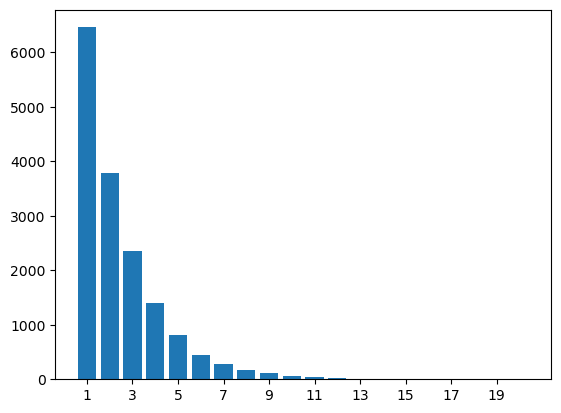

39721 observations reduced to 15999 clusters


In [9]:
h,x=np.histogram(a=nMems,bins=np.arange(0.5,20.51,1.))
xc=0.5*(x[0:-1] + x[1:])
plt.bar(x=xc,height=h)
plt.xticks(ticks=xc[::2],labels=xc[::2].astype(int))
plt.show()
print('{:d} observations reduced to {:d} clusters'.format(len(gdfE2),np.size(np.unique(gdfE2['clusterIndex']))))

In [10]:
# sanity check: standard deviation of distance from [lat=0.,lon=0.], pressure, time, uob, and vob per cluster
cids = np.unique(gdfE2['clusterIndex'].values)
stdv_dist=np.nan * np.ones((np.size(cids),))
stdv_pres=np.nan * np.ones((np.size(cids),))
stdv_time=np.nan * np.ones((np.size(cids),))
stdv_uwnd=np.nan * np.ones((np.size(cids),))
stdv_vwnd=np.nan * np.ones((np.size(cids),))
for i in range(np.size(cids)):
    cid = cids[i]
    if np.size(gdfE.loc[gdfE2['clusterIndex']==cid,'lat'].values) > 1:
        stdv_dist[i] = np.std(haversine_np(gdfE2.loc[gdfE2['clusterIndex']==cid,'lat'].values,
                                           gdfE2.loc[gdfE2['clusterIndex']==cid,'lon'].values,
                                           0.,
                                           0.))
        stdv_pres[i] = np.std(gdfE2.loc[gdfE2['clusterIndex']==cid,'pre'].values)
        stdv_time[i] = np.std(gdfE2.loc[gdfE2['clusterIndex']==cid,'tim'].values)
        stdv_uwnd[i] = np.std(gdfE2.loc[gdfE2['clusterIndex']==cid,'uob'].values)
        stdv_vwnd[i] = np.std(gdfE2.loc[gdfE2['clusterIndex']==cid,'vob'].values)
    
    
    

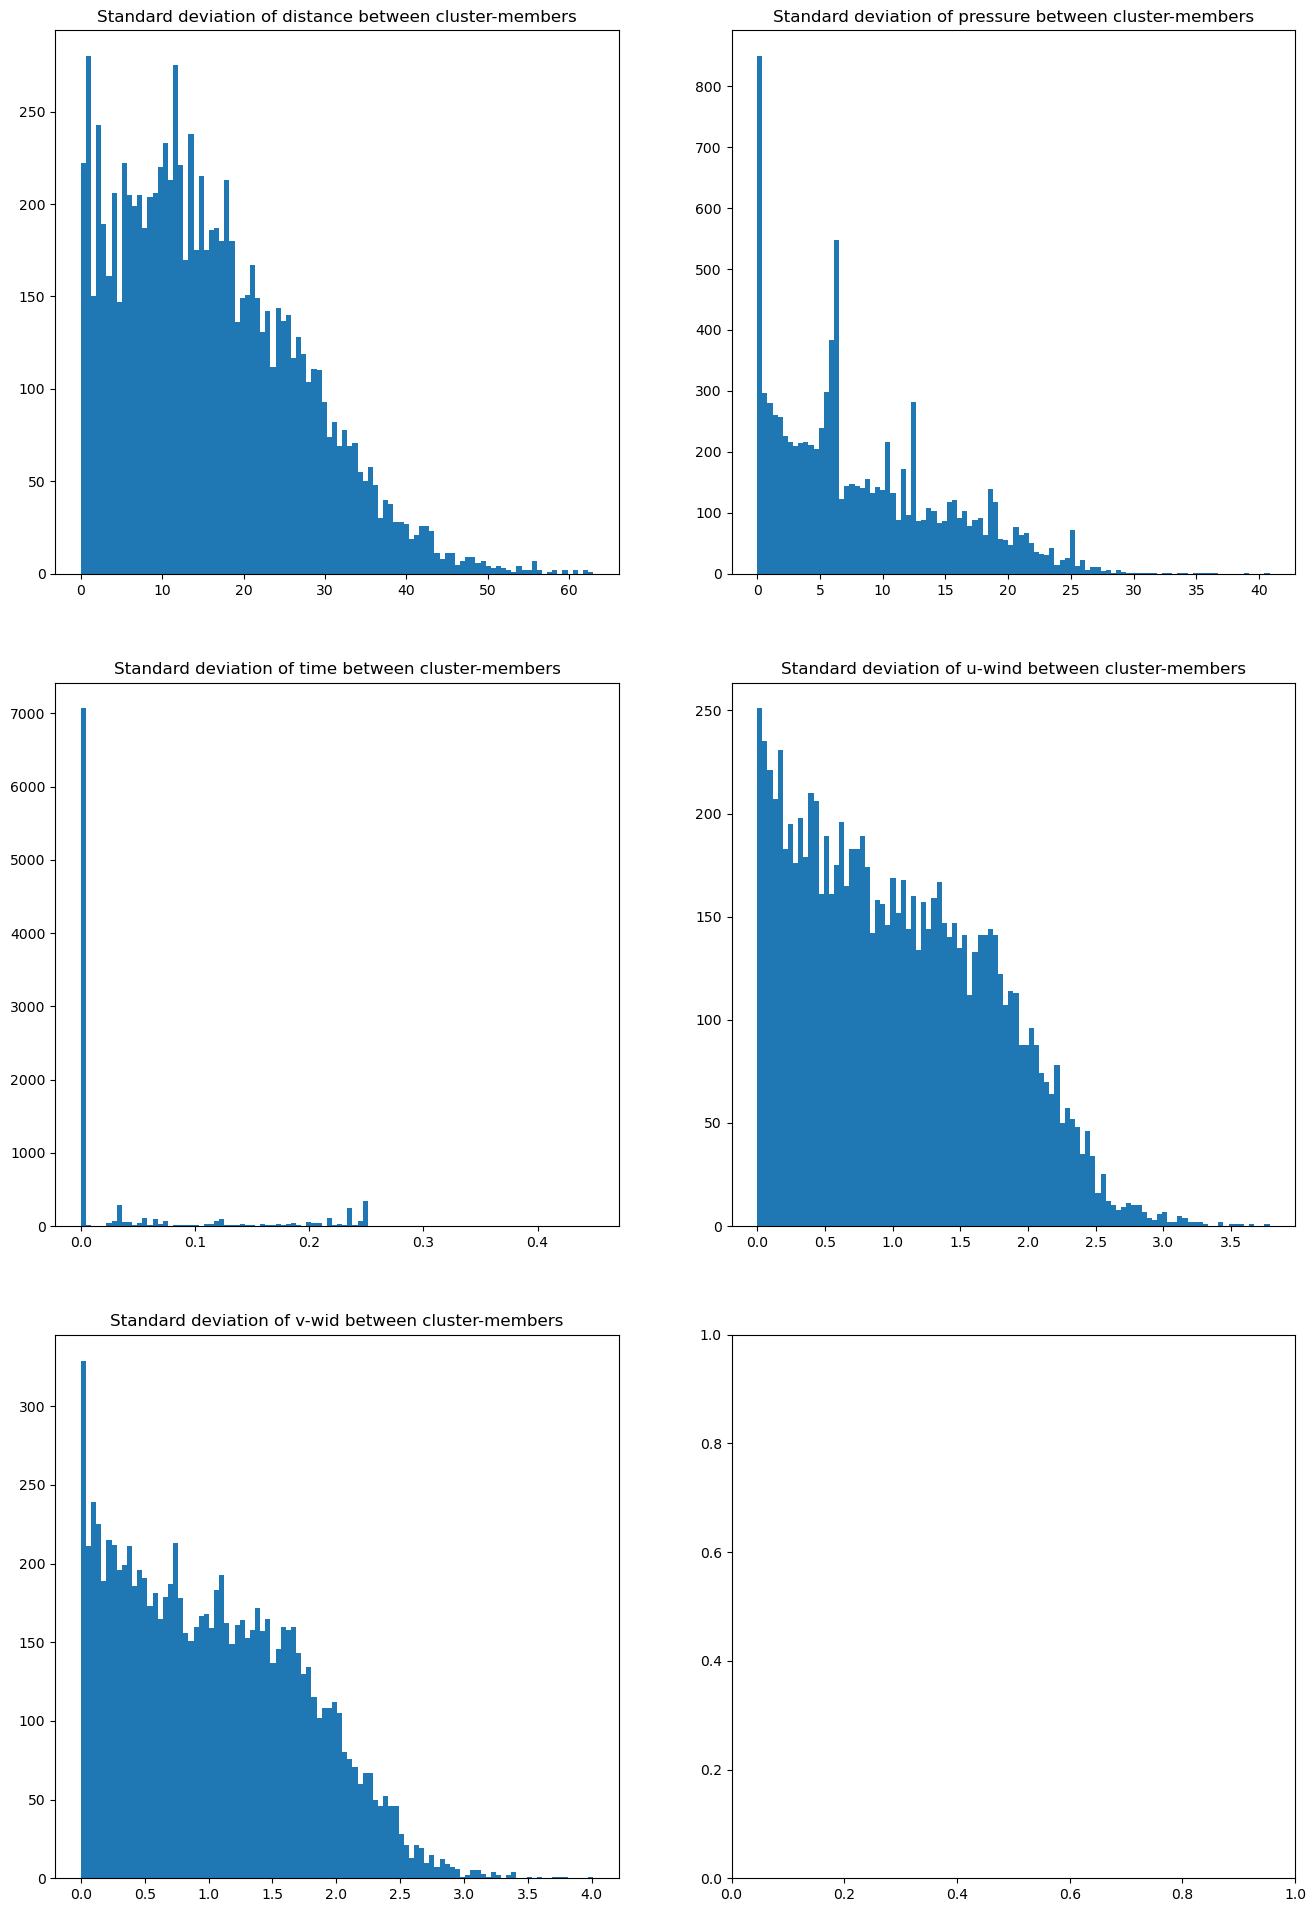

In [11]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(16,24))
ax=axs[0][0]
ax.hist(stdv_dist,100)
ax.set_title('Standard deviation of distance between cluster-members')
ax=axs[0][1]
ax.hist(stdv_pres,100)
ax.set_title('Standard deviation of pressure between cluster-members')
ax=axs[1][0]
ax.hist(stdv_time,100)
ax.set_title('Standard deviation of time between cluster-members')
ax=axs[1][1]
ax.hist(stdv_uwnd,100)
ax.set_title('Standard deviation of u-wind between cluster-members')
ax=axs[2][0]
ax.hist(stdv_vwnd,100)
ax.set_title('Standard deviation of v-wid between cluster-members')
plt.show()

In [12]:
# Some notes about this method:
#
# 1) I am very pleased with the simple nature of the clustering as the intersection of
#    neighborhoods among observations in the same proximity in time, space, and similarity
#    in u- and v-wind components. The threshold values that define these neighborhoods are
#    physically meaningful and represent the hyperparameters that are being applied. These
#    hyperparameters can be modified based on desired cluster-size or can change depending
#    on the pressure-level or other characteristics of the obs as-needed.
#
# 2) The departure from traditional clustering techniques appears to help with avoiding
#    running into arbitrary lines of demarcation that a clustering algorithm like OPTICS will
#    form by splitting observations into similarity groups. Often there are observations right
#    on the periphery between two of these similarity grouping clusters, which would be nice
#    to group together, but are considered to be separated. Relying on a network of neighborhood
#    relationships via sklearn.neighbors.NearestNeighbors() seems to provide more meaningful
#    distinctions between clusters.
#
# 3) Similarly to (2), departing from clustering algorithms also avoids some randomness in the
#    result, which would be confounding for controlled experiments if they weren't explicitly
#    accounted-for. OPTICS, for example, allows for a random seed to be chosen to make the
#    results reproducible, but is this the way we would want to work in operations? The results
#    here are reproducible on their own.
#
# 4) I noticed that in my loop across observations within a component-group to find clusters, the
#    result changed when I included an if-trap to cycle the loop if the observation being clustered
#    around already had a clusterIndex value. The result tends to be to create fewer clusters with
#    a greater number of larger-membership clusters and fewer single-membership clusters. I would
#    imagine that the result is also changeable by reordering the input data, which is not explicitly
#    a desirable quality and could lead to non-reproducibility on its own. Since observations can be
#    contacted multiple times in the clustering search but are only assigned to a cluster if they are
#    so-far unassigned, the cluster that any particular observation ends up in can be different depending
#    on the order in which this search traverses the data.
#
# 5) The data sub-setting that takes place prior to clustering, which defines the data that goes into
#    gdfE, will require more examination. I am relying on a "patch" or "tile plus halo" approach to split
#    the data into sub-sets that will include overlapping regions that are considered for clustering multiple
#    times. This is related to issues in (4): what do we do about observations that are candidates for being
#    in multiple clusters? Can we allow observations to be super-obbed more than once? If we choose to go with
#    only the first (or last, or anything in-between) assignment to a cluster, then the order in which the
#    clustering happens affects the outcome.

In [13]:
# A handy converter between EPSG:4087 and EPSG:4326 formats (x,y --> lon,lat)
import pyproj
xval=gdfE2['geometry'].values[0:10].x
yval=gdfE2['geometry'].values[0:10].y
proj = pyproj.Transformer.from_crs(4087, 4326, always_xy=True)
lonval, latval = proj.transform(xval, yval)
print(lonval,latval)

[1.         8.43999958 8.27999973 4.94999981 6.57999992 6.88000011
 8.82999992 2.8900001  9.06999969 0.16      ] [-81.16000366 -80.97000122 -81.58999634 -81.97000122 -81.94999695
 -82.29000092 -82.23999786 -82.76000214 -82.68000031 -83.29000092]


In [14]:
# compute superObs from clusters
#
# superOb location in pressure and time is taken as the mean value among cluster-members, while the
# latitude and longitude are taken as the values from the mean EPSG:4087 (x,y) values. This is done
# because the (x,y) values are in an equidistant coordinate system, while (lon,lat) values are not.
#
# create a pyproj.Transformer() object to convert between EPSG:4087 (x,y)-space and EPSG:4086 (lon,lat)-space
proj = pyproj.Transformer.from_crs(4087, 4326, always_xy=True)
# generate superobs from clusters, store in arrays
nClusters = np.size(np.unique(gdfE2['clusterIndex'].values))
SOyval=np.nan * np.ones((nClusters,))  # superob y-value (EPSG:4087 format)
SOxval=np.nan * np.ones((nClusters,))  # superob x-value (EPSG:4087 format)
SOlat=np.nan * np.ones((nClusters,))   # superob latitude (EPSG:4326 format)
SOlon=np.nan * np.ones((nClusters,))   # superob longitude (EPSG:4326 format)
SOpre=np.nan * np.ones((nClusters,))
SOtim=np.nan * np.ones((nClusters,))
SOuob=np.nan * np.ones((nClusters,))
SOvob=np.nan * np.ones((nClusters,))
SOnob=np.nan * np.ones((nClusters,))   # superob metadata: number of AMVs in superob
for i in range(nClusters):
    c = np.unique(gdfE2['clusterIndex'].values)[i]
    y = gdfE2.loc[gdfE2['clusterIndex']==c]
    SOxval[i] = np.mean(y['geometry'].values.x)
    SOyval[i] = np.mean(y['geometry'].values.y)
    # compute effective lat, lon from x, y
    SOlon[i], SOlat[i] = proj.transform(SOxval[i], SOyval[i])
    SOpre[i] = np.mean(y['pre'].values)
    SOtim[i] = np.mean(y['tim'].values)
    SOuob[i] = np.mean(y['uob'].values)
    SOvob[i] = np.mean(y['vob'].values)
    SOnob[i] = np.size(y['lat'].values)
# let's try making density-maps of the data, by computing the number of observations in regular 100km x 100km boxes
yedges = np.arange(np.min(gdfE2['geometry'].values.y)-50.0*1000., np.max(gdfE2['geometry'].values.y)+50.1*1000., 100.*1000.)
xedges = np.arange(np.min(gdfE2['geometry'].values.x)-50.0*1000., np.max(gdfE2['geometry'].values.x)+50.1*1000., 100.*1000.)
H, xedges, yedges = np.histogram2d(gdfE2['geometry'].values.x,gdfE2['geometry'].values.y, bins=(xedges, yedges))
AMVdens = H.T 
H = np.histogram2d(SOxval,SOyval, bins=(xedges, yedges))[0]
SOdens = H.T
Xc, Yc = np.meshgrid(0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1]))  # meshgrid centers, as average of bin-edges

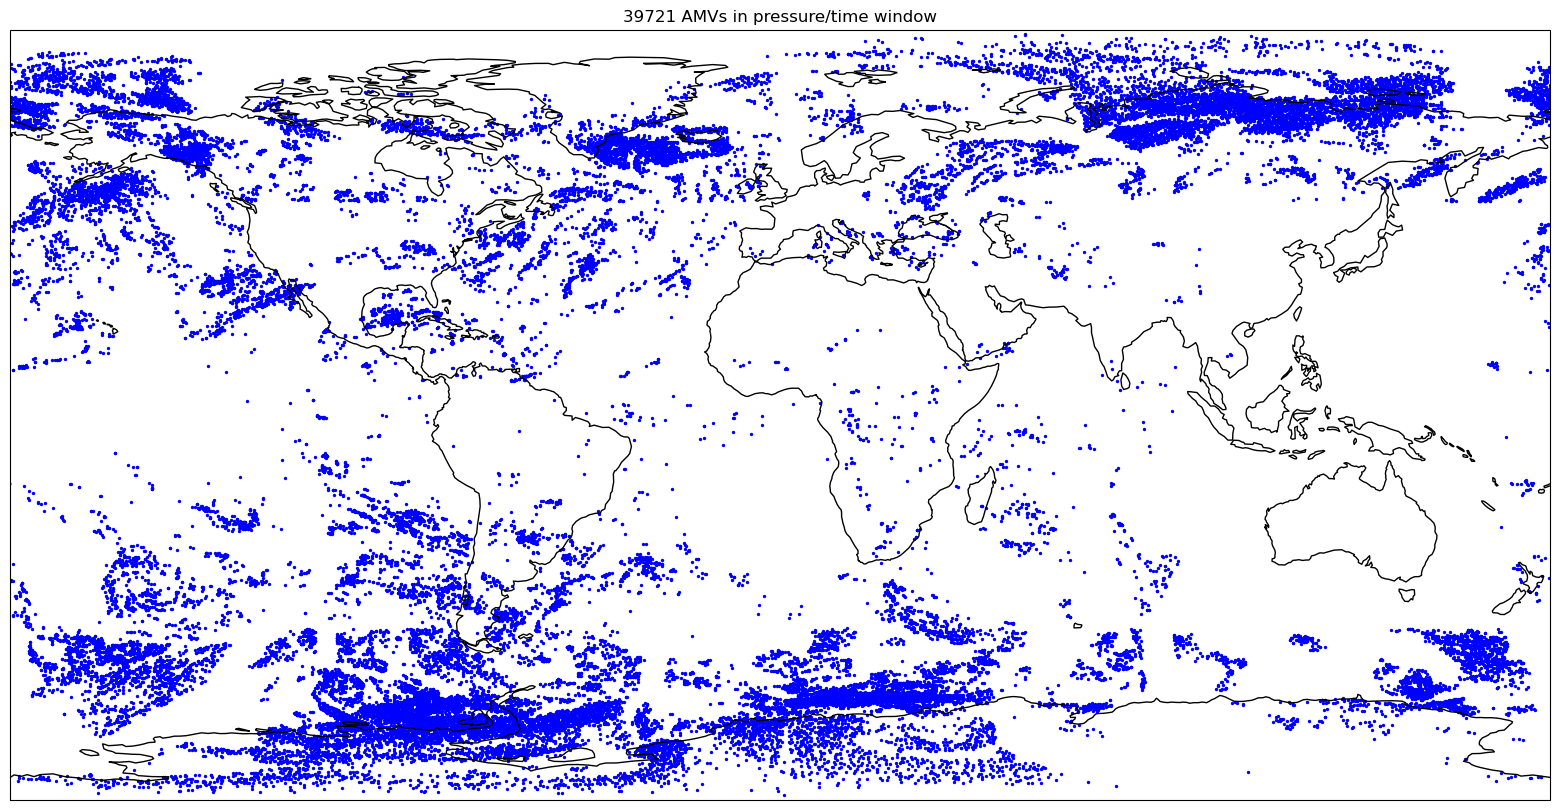

In [15]:
# plot AMVs in pressure/time window
nCompGroups = np.size(np.unique(gdfE2['compGroup'].values))

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(20,10), subplot_kw={'projection' : ccrs.PlateCarree()})

scalarMap = cm.ScalarMappable(cmap='jet')
scalarMapList = scalarMap.to_rgba(range(20))

ax=axs
ax.scatter(gdfE2['lon'].values, gdfE2['lat'].values, s=2.0, color='blue', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, edgecolor='black')
ax.set_title('{:d} AMVs in pressure/time window'.format(len(gdfE2)))
plt.show()

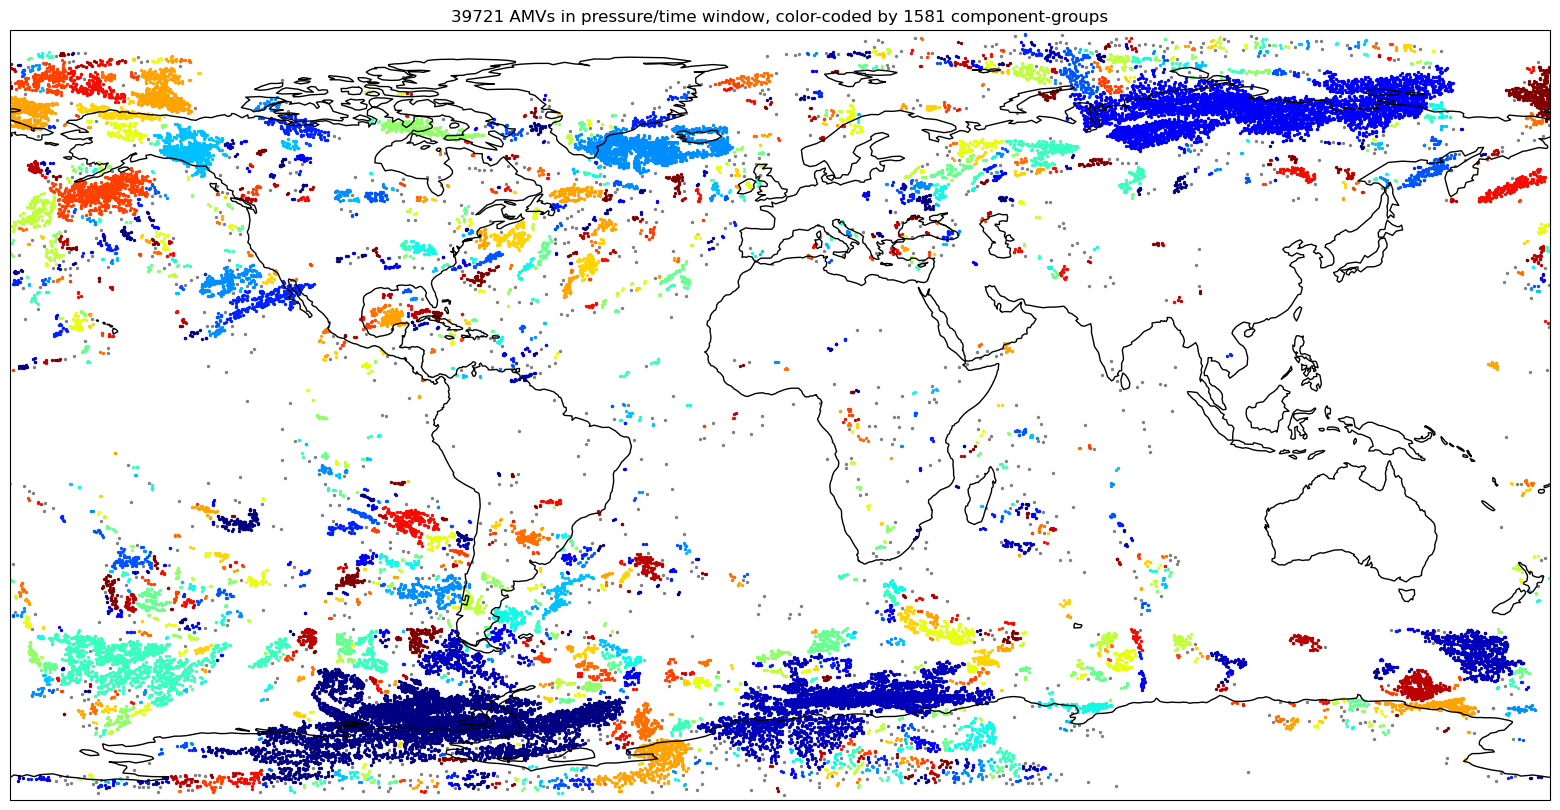

In [16]:
# plot AMVs color-coded by component-group
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(20,10), subplot_kw={'projection' : ccrs.PlateCarree()})
ax=axs
for i in range(nCompGroups):
    cg = np.unique(gdfE2['compGroup'].values)[i]
    x = gdfE2.loc[gdfE2['compGroup'] == cg]
    j=i
    while j > 19:
        j -= 20
    pcol=list(scalarMapList[j][0:3])
    if cg == -1:
        pcol='gray'
    ax.scatter(x['lon'].values, x['lat'].values, s=2.0, color=pcol, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, edgecolor='black')
ax.set_title('{:d} AMVs in pressure/time window, color-coded by {:d} component-groups'.format(len(gdfE2),nCompGroups))
plt.show()

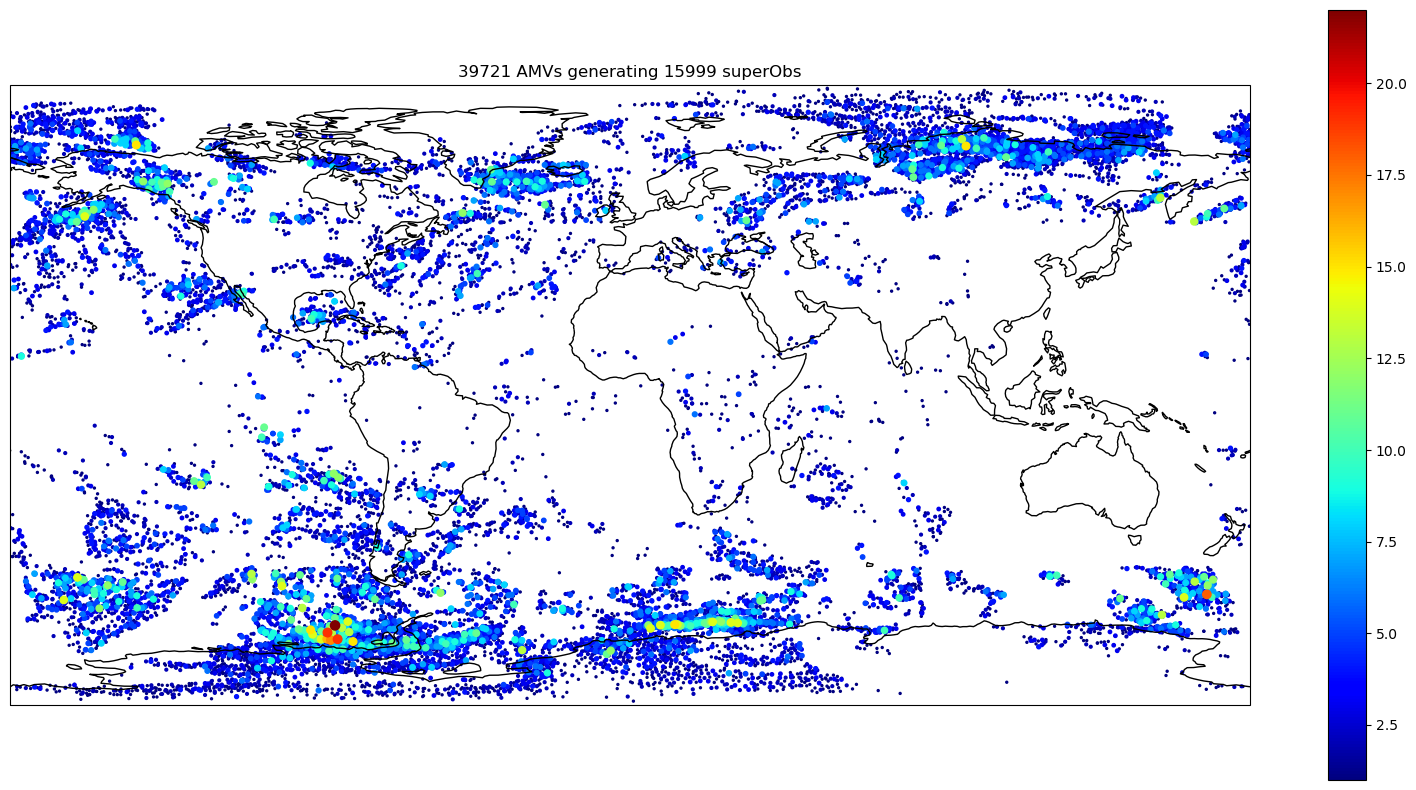

In [17]:
# plot superObs, color-coded and sized by number of cluster-members
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(20,10), subplot_kw={'projection' : ccrs.PlateCarree()})
ax=axs
nobSort = np.argsort(SOnob)
sct=ax.scatter(SOlon[nobSort], y=SOlat[nobSort], s=2.*SOnob[nobSort], c=SOnob[nobSort], cmap='jet', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, edgecolor='black')
ax.set_title('{:d} AMVs generating {:d} superObs'.format(len(gdfE2),nClusters))
plt.colorbar(mappable=sct, ax=ax)
plt.show()

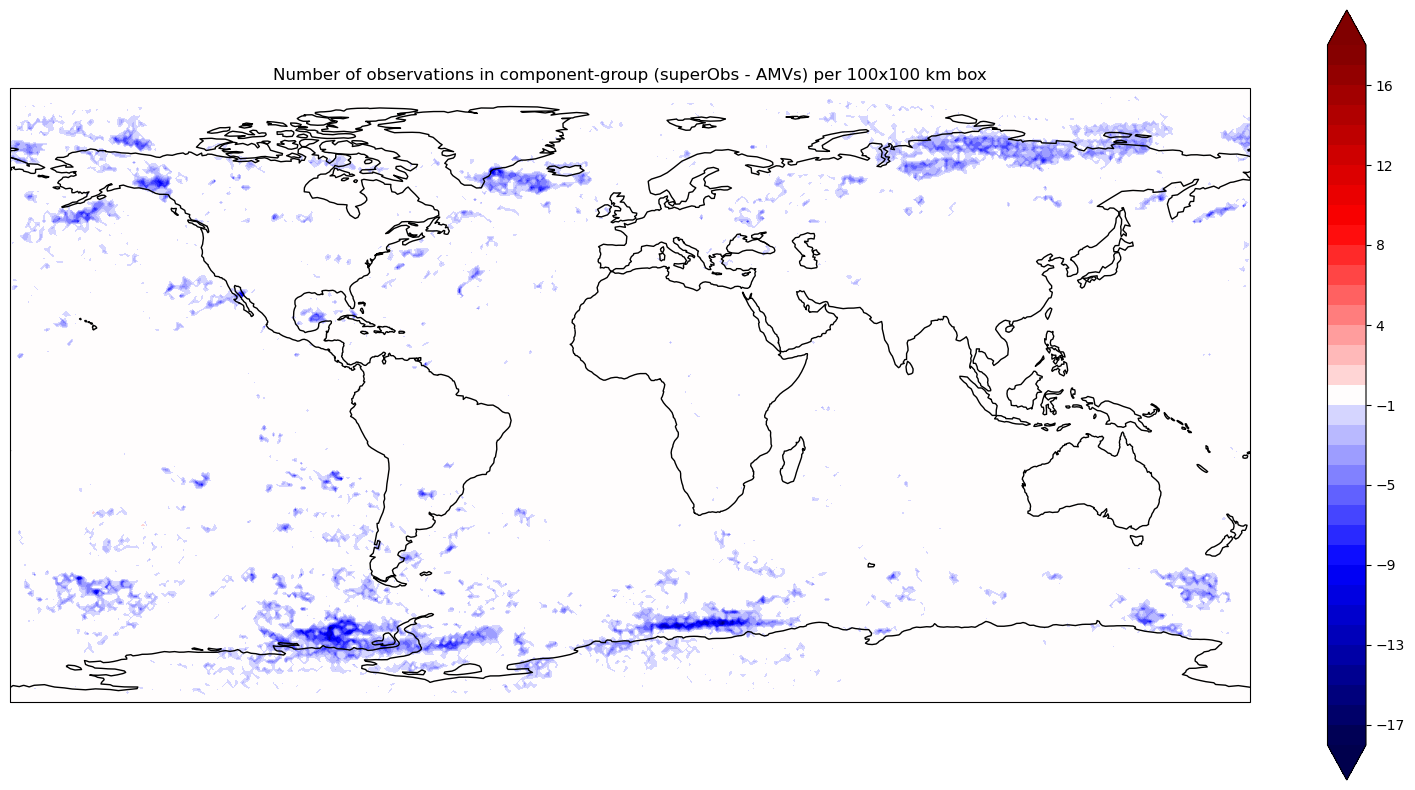

In [18]:
# plot difference in number of obs (superobs - AMVs) per 100km box
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(20,10), subplot_kw={'projection' : ccrs.PlateCarree()})
ax=axs
shdRange = np.arange(-18., 18.1, 1.)
shdMask = np.ones(np.shape(shdRange), dtype=bool)
shdMask[np.where(shdRange==0.)] = False
figLon, figLat = proj.transform(Xc, Yc)
shd = ax.contourf(figLon, figLat, SOdens-AMVdens, shdRange[shdMask], cmap='seismic', vmin=np.min(shdRange), vmax=np.max(shdRange), extend='both', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, edgecolor='black')
plt.colorbar(mappable=shd, ax=ax)
ax.set_title('Number of observations in component-group (superObs - AMVs) per 100x100 km box')
plt.show()

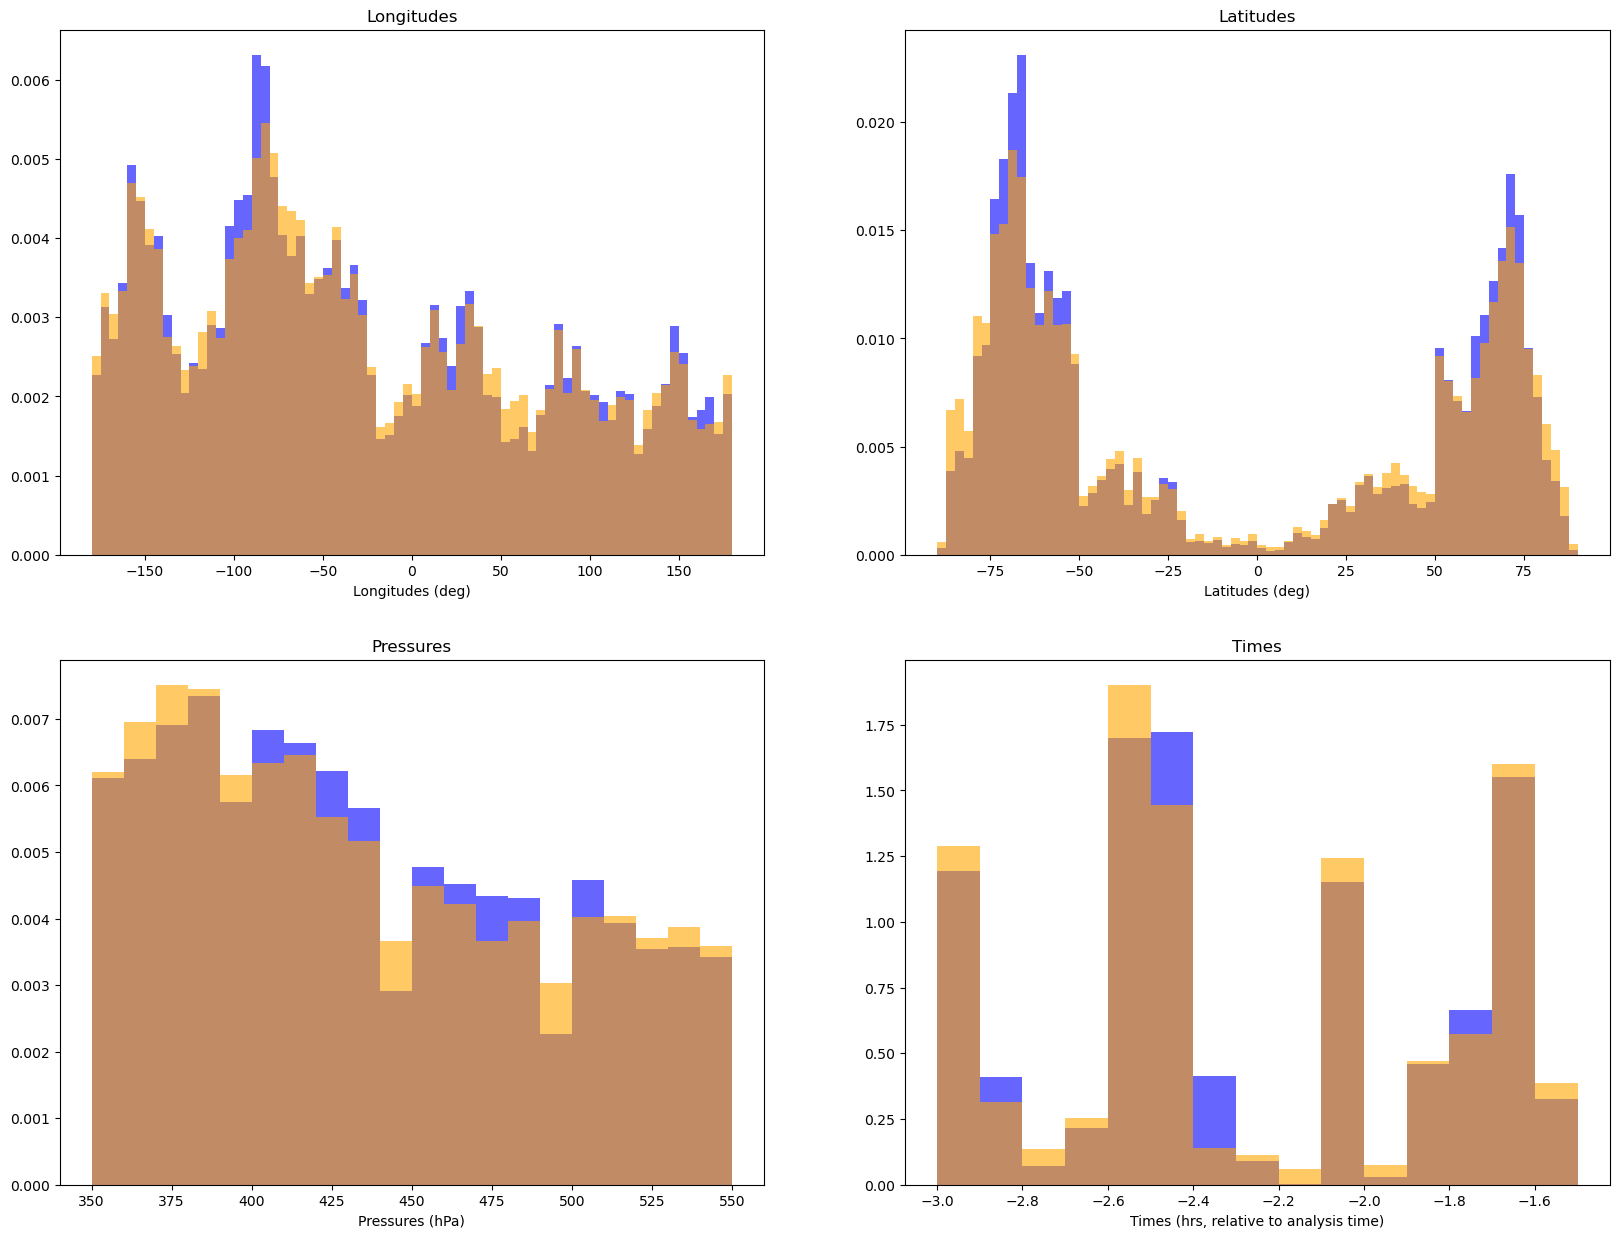

In [20]:
# plots: histograms of AMV vs superob spatio-temporal distributions
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20,15))
# 1: longitudes
ax=axs[0][0]
ax.hist(gdfE2['lon'].values,np.arange(-180.,180.1,5.),color='blue',alpha=0.6,density=True)
ax.hist(SOlon,np.arange(-180.,180.1,5.),color='orange',alpha=0.6,density=True)
ax.set_title('Longitudes')
ax.set_xlabel('Longitudes (deg)')
# 2: latitudes
ax=axs[0][1]
ax.hist(gdfE2['lat'].values,np.arange(-90.,90.1,2.5),color='blue',alpha=0.6,density=True)
ax.hist(SOlat,np.arange(-90.,90.1,2.5),color='orange',alpha=0.6,density=True)
ax.set_title('Latitudes')
ax.set_xlabel('Latitudes (deg)')
# 3: pressures
ax=axs[1][0]
ax.hist(gdfE2['pre'].values,np.arange(350.,550.1,10),color='blue',alpha=0.6,density=True)
ax.hist(SOpre,np.arange(350.,550.1,10),color='orange',alpha=0.6,density=True)
ax.set_title('Pressures')
ax.set_xlabel('Pressures (hPa)')
# 4: times
ax=axs[1][1]
ax.hist(gdfE2['tim'].values,np.arange(-3.,-1.49,0.1),color='blue',alpha=0.6,density=True)
ax.hist(SOtim,np.arange(-3.,-1.49,0.1),color='orange',alpha=0.6,density=True)
ax.set_title('Times')
ax.set_xlabel('Times (hrs, relative to analysis time)')
plt.show()